In [35]:
import uproot 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
    
import scipy.integrate as integrate
import scipy.stats as ss

from scipy.optimize import curve_fit 
from scipy.special import erf

In [36]:
# using the data just after the mass(phi) cut, instead of after the mass(Bs) cut
# this is because we are limited by the simulation samples
# and this assumes that bkg have the same Delta_t distribution before and after the cut
# (which is OK assumption, and even this doesn't hold, later we will see that the main prolem is not from the bkg, just the signal flauctation)
# FOLDER_NAME = './preselect_mPhi/'
FOLDER_NAME = './preselect_q2/'

# File paths for signal, bb, and cc datasets
FILE_NAME_DT = {
    "sig.":   FOLDER_NAME + "ee2Z2Bs2PhiMuMu_preselect.root",
    "bb":     FOLDER_NAME + "ee2Z2b_comb_cutted_preselect.root",
    "cc":     FOLDER_NAME + "ee2Z2c_comb_cutted_preselect.root",
}

# Load root files using uproot and convert to DataFrame
FILE_DT = {key: uproot.open(path) for key, path in FILE_NAME_DT.items()}
DF_DT = {key: pd.DataFrame(np.array(FILE_DT[key]['t'].arrays())).set_index('index') for key in FILE_DT}

# Yields after the mass cuts
YIELD_DT = {
    "sig.":   6.27e4,
    "bb":     1.40e3,
    "cc":     2.13e2,
}

In [38]:
# Define the range for the time interval (in seconds)
range_ = [1e-12, 8e-12]

# Define the number of bins: 35 for untagged, 105 for tagged 
# bins_ = 35
bins_ = 70 + 35

# One period of Bs oscillation is approximately 0.35 ps
# According to the Nyquist–Shannon sampling theorem, we should have at least 2 data points within one period.
# Following some LHCb papers, we can use 0.1 ps per bin for better sampling.

# Factor to smooth the plot by oversampling (sampling 'fac_' times more points per bin)
fac_ = 10

In [39]:
# Time dilution factor calculation
# This formula likely represents a Gaussian suppression factor for time dilation.
# The numbers used (0.00543 and 17.765) are specific to your model or dataset.
D_time = np.exp(-0.00543**2 * 17.765**2 / 2)

# Tagging power for different experiments (unitless fraction or probability)
# P_bm, P_LEP, P_Babar, and P_LHCb represent the tagging efficiencies for different experiments or detectors.
P_bm = 0.35    # Tagging power for benchmark
P_LEP = 0.25   # Tagging power for LEP experiment
P_Babar = 0.3  # Tagging power for Babar experiment
P_LHCb = 0.06  # Tagging power for LHCb experiment


In [40]:
# Different cases of the variables of the CP observables

Df_SM, Cf_SM, Sf_SM = -0.71, 0, 0
# Df_SM, Cf_SM, Sf_SM = -0.71, 0, 0.06
# Df_SM, Cf_SM, Sf_SM = -0.71, 0.03, 0.06


In [41]:
# Transform the DV (decay vertex) position into the proper time (Delta_t)
# DV is in millimeters, and Delta_t will be calculated in seconds.
def get_Dt(df):
    df['gamma'] = df['EBs'] / (df['mBs'] * (3e8 ** 2))
    df['beta'] = df['PBs'] * 3e8 / df['EBs']
    df['Delta_t'] = df['DV'] * 0.001 / (df['beta'] * df['gamma'] * (3e8 ** 2))
    return df

In [42]:
# Apply the mass cut to the signal samples (5.35 < mBs < 5.39)
df_s_ = DF_DT['sig.']
df_s = df_s_[(df_s_.mBs > 5.35) & (df_s_.mBs < 5.39)].copy()

# No mass cuts for bb and cc samples (lack of simluation)
# assume the time and the m(Bs) are independent, so can use the data before the mass cut
df_b = DF_DT['bb']
df_c = DF_DT['cc']

# Transform the DV position to proper time (Delta_t) for signal, bb, and cc samples
df_s = get_Dt(df_s)
df_b = get_Dt(df_b)
df_c = get_Dt(df_c)

# Efficiency calculation for Delta_t within the defined range
eff_s = len(df_s[(df_s['Delta_t'] > range_[0]) & (df_s['Delta_t'] < range_[1])]) / len(df_s)
eff_b = len(df_b[(df_b['Delta_t'] > range_[0]) & (df_b['Delta_t'] < range_[1])]) / len(df_b)
eff_c = len(df_c[(df_c['Delta_t'] > range_[0]) & (df_c['Delta_t'] < range_[1])]) / len(df_c)

# Calculate weights for each sample based on the expected yields
w_s_h = [YIELD_DT['sig.'] / len(df_s['mBs'])] * len(df_s['mBs'])
w_b_h = [YIELD_DT['bb'] / len(DF_DT['bb']['mBs'])] * len(DF_DT['bb']['mBs'])
w_c_h = [YIELD_DT['cc'] / len(DF_DT['cc']['mBs'])] * len(DF_DT['cc']['mBs'])

# Assign preweights to the signal sample based on the expected yield
df_s['preweight'] = w_s_h


### uncert. of AP (time indep.)

$\delta A = \frac{1}{\sqrt{P}}\sqrt{\frac{1-A^2}{N}}$
and approximate $A\sim 0$

In [43]:
# Calculate the expected yields for signal (S) and background (B)
n_S = YIELD_DT['sig.']  # Yield for signal
n_B = YIELD_DT['bb'] + YIELD_DT['cc']  # Combined yield for bb and cc backgrounds

# Uncertainty in A based on the formula: 
# uncert_A = sqrt((1/P) * (1 - A^2) / N)
# Here, we calculate the first part of the uncertainty: (1 / N)^0.5 for convenience
uncert_N = n_S**-0.5


In [44]:
# Calculate the uncertainties for different experiments based on tagging power
uncert_bm = uncert_N / (P_bm**0.5)
uncert_LEP = uncert_N / (P_LEP**0.5)
uncert_Babar = uncert_N / (P_Babar**0.5)
uncert_LHCb = uncert_N / (P_LHCb**0.5)


In [45]:
# Generate an array of tagging powers (Ps) ranging from P_LHCb to 1 with 100 points
Ps = np.linspace(P_LHCb, 1, 100)

# Calculate the uncertainty for each tagging power in Ps
uncert_lt = uncert_N / (Ps**0.5)

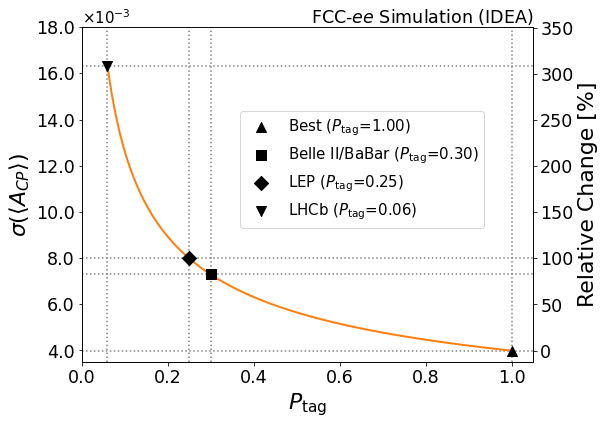

In [46]:
# Create the figure and axis objects
f, ax = plt.subplots(1, figsize=(8.5, 6))

# Plot the uncertainty curve for different tagging powers (Ps)
plt.plot(Ps, uncert_lt, lw=2, zorder=0, color='C1')

# Add horizontal and vertical reference lines for the min/max tagging powers and uncertainties
plt.axhline(uncert_lt[-1], linestyle=':', color='grey', zorder=-1)  # Horizontal line at max P
plt.axvline(Ps[-1], linestyle=':', color='grey', zorder=-1)  # Vertical line at max P
plt.axhline(uncert_lt[0], linestyle=':', color='grey', zorder=-1)  # Horizontal line at min P
plt.axvline(Ps[0], linestyle=':', color='grey', zorder=-1)  # Vertical line at min P

# Add reference lines for LEP and Babar uncertainties
plt.axhline(uncert_LEP, linestyle=':', color='grey', zorder=-1)
plt.axvline(P_LEP, linestyle=':', color='grey', zorder=-1)
plt.axhline(uncert_Babar, linestyle=':', color='grey', zorder=-1)
plt.axvline(P_Babar, linestyle=':', color='grey', zorder=-1)

# Scatter plot markers for best, Belle II/BaBar, LEP, and LHCb tagging power points
plt.scatter(Ps[-1], uncert_lt[-1], color='k', s=100, label=r'Best ($P_{\rm tag}$'+f'={Ps[-1]:.2f})', marker='^')
plt.scatter(P_Babar, uncert_Babar, s=100, color='k', label=r'Belle II/BaBar ($P_{\rm tag}$'+f'={P_Babar:.2f})', marker='s')
plt.scatter(P_LEP, uncert_LEP, s=100, color='k', label=r'LEP ($P_{\rm tag}$'+f'={P_LEP:.2f})', marker='D')
plt.scatter(P_LHCb, uncert_LHCb, s=100, color='k', label=r'LHCb ($P_{\rm tag}$'+f'={P_LHCb:.2f})', marker='v')

# Set labels for the x and y axes
ax.set_xlabel(r"$P_{\rm tag}$", fontsize=22)
ax.set_ylabel(r"$\sigma\left(\langle A_{CP}\rangle\right)$", fontsize=22)

# Set tick label size
ax.tick_params(axis='both', which='major', labelsize=17.5)

# Add a legend
ax.legend(fontsize=15, loc=(0.35, 0.4))

# Format y-axis tick labels to display in scientific notation and scale by 1e3
locs = ax.get_yticks()
ax.set_yticks(locs, map(lambda x: "%.1f" % (x * 1e3), locs))
ax.text(0, 1.01, r'$\times 10^{-3}$', fontsize=15, transform=plt.gca().transAxes)

# Add a title or additional annotation
ax.text(1, 1.03, r'FCC-$ee$ Simulation (IDEA)', horizontalalignment='right',
        verticalalignment='center', transform=ax.transAxes, fontsize=17.5)

# Set the limits for the x-axis and y-axis
ax.set_xlim(0, 1.05)
ax.set_ylim(0.35e-2, 1.8e-2)

# Create a secondary y-axis to show the relative change in uncertainty
ax2 = ax.twinx()
mn, mx = ax.get_ylim()
ax2.set_ylim(100 * (mn / uncert_lt[-1] - 1), 100 * (mx / uncert_lt[-1] - 1))
ax2.tick_params(axis='both', which='major', labelsize=17.5)
ax2.set_ylabel(f"Relative Change [%]", fontsize=22)

plt.tight_layout()
# f.savefig("acp_best.pdf")
plt.show()


### Get the raw distribution, and the uncertainty

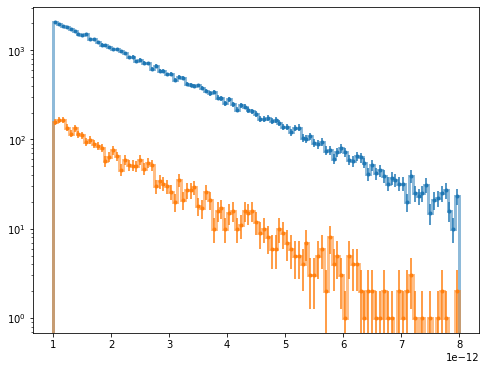

In [47]:
# This is the plot without the weights
# This is to account for the statistical uncertainty from the simulation
# To have a conservative estimate, the signal can fluctuate down while the background goes up

# Create the figure and axis for the plot
f, ax = plt.subplots(1, figsize=(8, 6))

# Plot histograms for signal and backgrounds
ns_raw, edges, _ = plt.hist(df_s['Delta_t'], histtype='step', lw=3, alpha=0.5, range=range_, bins=bins_)
nb_raw, _, _ = plt.hist(df_b['Delta_t'], histtype='step', lw=3, alpha=0.5, range=range_, bins=bins_)
nc_raw, _, _ = plt.hist(df_c['Delta_t'], histtype='step', lw=3, alpha=0.5, range=range_, bins=bins_)

# Error bars for the histograms
plt.errorbar((edges[1:] + edges[:-1]) / 2, ns_raw, yerr=np.sqrt(ns_raw), fmt='C0.')
plt.errorbar((edges[1:] + edges[:-1]) / 2, nb_raw, yerr=np.sqrt(nb_raw), fmt='C1.')
plt.errorbar((edges[1:] + edges[:-1]) / 2, nc_raw, yerr=np.sqrt(nc_raw), fmt='C2.')

# Set the y-axis to logarithmic scale
plt.yscale('log')

# Calculate relative uncertainties for the raw counts
def calculate_relative_uncertainty(raw_counts):
    """Calculate relative uncertainties based on raw counts."""
    rel_uncert = np.zeros_like(raw_counts)
    with np.errstate(divide='ignore', invalid='ignore'):
        rel_uncert = np.where(raw_counts > 0, raw_counts**-0.5, 1)  # Avoid division by zero
    return rel_uncert

ns_rel_uncert = calculate_relative_uncertainty(ns_raw)
nb_rel_uncert = calculate_relative_uncertainty(nb_raw)
nc_rel_uncert = calculate_relative_uncertainty(nc_raw)

# Discount factors based on uncertainty estimates
ns_discount = 1 - ns_rel_uncert  # If underestimating signal
nb_discount = 1 + nb_rel_uncert  # If overestimating background
nc_discount = 1 + nc_rel_uncert  # If overestimating background

# Show the plot
plt.show()

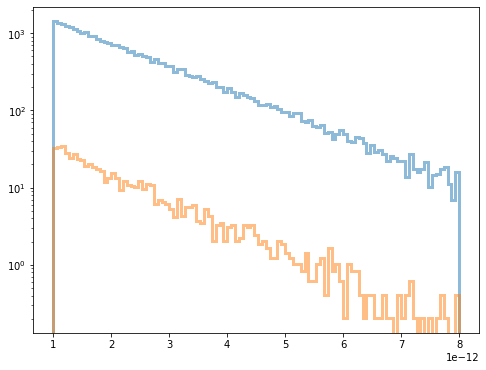

In [48]:
# get an idea of the scale of the signal and bkg
f, ax = plt.subplots(1, figsize=(8,6))
ns, edges, __ = plt.hist(df_s['Delta_t'], histtype='step', lw=3, alpha=0.5, weights=w_s_h, range=range_, bins=bins_);
nb, _, __ = plt.hist(df_b['Delta_t'], histtype='step', lw=3, alpha=0.5, weights=w_b_h, range=range_, bins=bins_);
nc, _, __ = plt.hist(df_c['Delta_t'], histtype='step', lw=3, alpha=0.5, weights=w_c_h, range=range_, bins=bins_);

plt.yscale('log')

### Theoretical distribution

In [49]:
# from https://pdg.lbl.gov/2023/reviews/rpp2022-rev-b-bar-mixing.pdf
# Constants from the PDG
Gamma = 1 / 1.520 * 1e12  # decay width in s^-1
DeltaGamma = 0.084 * 1e12  # width difference in s^-1
Deltam = 17.765 * 1e12  # mass difference in s^-1

# PDF of the untagged case
def pdf_untagged(t, Df, N=1):
    """Probability density function for the untagged case."""
    return N * np.exp(-Gamma * t) * (np.cosh(0.5 * DeltaGamma * t) + Df * np.sinh(0.5 * DeltaGamma * t))


# PDF of the decay time
def pdf_decay(t, Df, Cf, Sf, N=1):
    """Probability density function for decay time."""
    return N * np.exp(-Gamma * t) * (
        np.cosh(0.5 * DeltaGamma * t) + Df * np.sinh(0.5 * DeltaGamma * t) +
        Cf * np.cos(Deltam * t) - Sf * np.sin(Deltam * t)
    )


# Pure exponential decay PDF
def pdf_exp(t, Gamma, N=1):
    """Pure exponential decay probability density function."""
    return N * np.exp(-Gamma * t)


# A_cp(t) with Df forced to 1
def pdf_acp(t, Cf, Sf):
    """A_cp(t) function with Df set to 1."""
    Df = 1
    return (Cf * np.cos(Deltam * t) - Sf * np.sin(Deltam * t)) / (
        np.cosh(0.5 * DeltaGamma * t) + Df * np.sinh(0.5 * DeltaGamma * t)
    )


# A_cp(t) with Df set to Df_SM
def pdf_acp_SM(t, Cf, Sf):
    """A_cp(t) function with Df set to Df_SM."""
    Df = Df_SM
    return (Cf * np.cos(Deltam * t) - Sf * np.sin(Deltam * t)) / (
        np.cosh(0.5 * DeltaGamma * t) + Df * np.sinh(0.5 * DeltaGamma * t)
    )


# A_cp(t) allowing Df to float
def pdf_acp1(t, Cf, Sf, Df):
    """A_cp(t) function with Df as a free parameter."""
    return (Cf * np.cos(Deltam * t) - Sf * np.sin(Deltam * t)) / (
        np.cosh(0.5 * DeltaGamma * t) + Df * np.sinh(0.5 * DeltaGamma * t)
    )


# A_cp(t) based on the real and imaginary parts of lambda
def pdf_acp_constraint(t, rl, img):
    """A_cp(t) function derived from the real and imaginary parts of lambda."""
    mag2 = rl**2 + img**2
    Df = 2 * rl / (1 + mag2)
    Cf = (1 - mag2) / (1 + mag2)
    Sf = 2 * img / (1 + mag2)
    return (Cf * np.cos(Deltam * t) - Sf * np.sin(Deltam * t)) / (
        np.cosh(0.5 * DeltaGamma * t) + Df * np.sinh(0.5 * DeltaGamma * t)
    )


# A_cp(t) with time modulated by 2pi/Delta m
def pdf_acp_mod(t, Cf, Sf):
    """A_cp(t) function with time modulated by Delta m."""
    return (Cf * np.cos(Deltam * t) - Sf * np.sin(Deltam * t))

### $D_f$

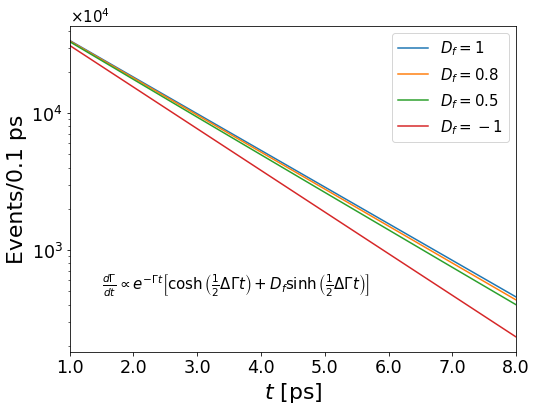

In [50]:
# Constants and parameters (Assumed previously defined)
# Ensure these variables are defined:
# range_ = (start_time, end_time) # e.g., (0, 1e-12) for 0 to 1 picosecond
# bins_ = 100  # Number of bins for the histogram
# fac_ = 10    # Factor to smoothen the plot
# YIELD_DT should have 'sig.' key with the appropriate yield value

# Time array for the plots
t = np.linspace(*range_, bins_ * fac_)

# Create the plot
f, ax = plt.subplots(1, figsize=(8, 6))

# Plotting PDFs with different Df values
df_values = [1, 0.8, 0.5, -1]
for df in df_values:
    plt.plot(t, pdf_untagged(t, df, YIELD_DT['sig.']), label=f'$D_f = {df}$')

# Customize y-axis ticks for better readability
locs = ax.get_yticks()
ax.set_yticks(locs, map(lambda x: "%.1f" % x, locs * 1e-4))
ax.text(0, 1.01, r'$\times 10^4$', fontsize=15, transform=plt.gca().transAxes)

# Customize x-axis ticks for better readability
locs = ax.get_xticks()
ax.set_xticks(locs, map(lambda x: "%.1f" % x, locs * 1e12))

# Set labels and styles
ax.set_xlabel(r"$t$ [ps]", fontsize=22)
ax.set_ylabel(f"Events/{(range_[1] - range_[0]) / bins_ * 1e12:.1f} ps", fontsize=22)
ax.tick_params(axis='both', which='major', labelsize=17.5)
ax.legend(fontsize=15)

# Set axis limits and margins
ax.set_xlim(*range_)
ax.margins(x=0.)

# Add a text annotation for the PDF formula
ax.text(1.5e-12, 5.2e2, r'$\frac{d\Gamma}{dt}\propto e^{-\Gamma t}\left[\cosh{\left(\frac{1}{2}\Delta\Gamma t\right)}+D_f\sinh{\left(\frac{1}{2}\Delta\Gamma t\right)}\right]$', fontsize=15)

# Set y-axis to logarithmic scale
plt.yscale('log')

plt.show()


### Do the bin-by-bin unfolding

In [51]:
def get_heights(curve, edges, t):
    """
    Calculate the heights of the bins based on the provided curve and edges.

    Parameters:
    curve : np.ndarray
        The values of the probability density function.
    edges : np.ndarray
        The bin edges defining the ranges for height calculation.
    t : np.ndarray
        The time points corresponding to the values in the curve.

    Returns:
    np.ndarray
        The heights of the bins.
    """
    # Initialize the heights array
    heights = np.zeros(len(edges) - 1)

    # Calculate heights using vectorized operations
    for i in range(len(edges) - 1):
        # Determine the mask for the current bin
        if i < len(edges) - 2:
            mask = (t >= edges[i]) & (t < edges[i + 1])
        else:  # For the last bin, include the upper edge
            mask = (t >= edges[i])
        
        heights[i] = curve[mask].sum()
    
    return heights


In [52]:
# Shuffle the dataset
idx = df_s.index.tolist()

np.random.seed(0)  # Set seed for reproducibility
np.random.shuffle(idx)  # Shuffle indices

# Split dataset into training and testing sets (50/50 split)
train_test_split = 0.5
split_index = int(len(idx) * train_test_split)
df_s_train = df_s.loc[idx[:split_index]]
df_s_test = df_s.loc[idx[split_index:]]

# Split the train/test into B/Bbar subgroups
df_s_B_train = df_s_train[df_s_train['BBbar_truth'] == 1]  # B events in training
df_s_B_test = df_s_test[df_s_test['BBbar_truth'] == 1]      # B events in testing
df_s_Bb_train = df_s_train[df_s_train['BBbar_truth'] == -1]  # Bbar events in training
df_s_Bb_test = df_s_test[df_s_test['BBbar_truth'] == -1]      # Bbar events in testing

# Concatenate to have complete datasets for B and Bbar
df_s_B = pd.concat([df_s_B_train, df_s_B_test], ignore_index=True)
df_s_Bb = pd.concat([df_s_Bb_train, df_s_Bb_test], ignore_index=True)

# Optional: Print the shapes of the resulting DataFrames
print("Training set B shape:", df_s_B_train.shape)
print("Testing set B shape:", df_s_B_test.shape)
print("Training set Bbar shape:", df_s_Bb_train.shape)
print("Testing set Bbar shape:", df_s_Bb_test.shape)


Training set B shape: (23163, 38)
Testing set B shape: (23161, 38)
Training set Bbar shape: (22333, 38)
Testing set Bbar shape: (22335, 38)


In [53]:
# Simulation of the Standard Model PDF for untagged decays
fac = 1  # Factor to smoothen the plot
t = np.linspace(*range_, bins_ * fac)  # Time range for evaluation

# Calculate the untagged PDF with Df = Df_SM
untag = pdf_untagged(t, Df_SM)

# Normalize the PDF to the expected yield at Z-pole
untag = untag / sum(untag) * (YIELD_DT['sig.']) * eff_s

# Calculate heights for untagged PDF
heights_ut = get_heights(untag, edges, t)

# Generate PDFs for B and Bbar decays
# Using the decay PDF with appropriate parameters for B and Bbar
exp1 = pdf_decay(t, Df_SM, Cf_SM, Sf_SM)  # For B
exp2 = pdf_decay(t, Df_SM, -Cf_SM, -Sf_SM)  # For Bbar

# Normalize the decay PDFs
exp1 = exp1 / sum(exp1) * (YIELD_DT['sig.']) / 2 * eff_s
exp2 = exp2 / sum(exp2) * (YIELD_DT['sig.']) / 2 * eff_s

# Calculate heights for B and Bbar decay PDFs
heights1 = get_heights(exp1, edges, t)  # Heights for B
heights2 = get_heights(exp2, edges, t)  # Heights for Bbar


#### Get the unfolding ratio of untagged

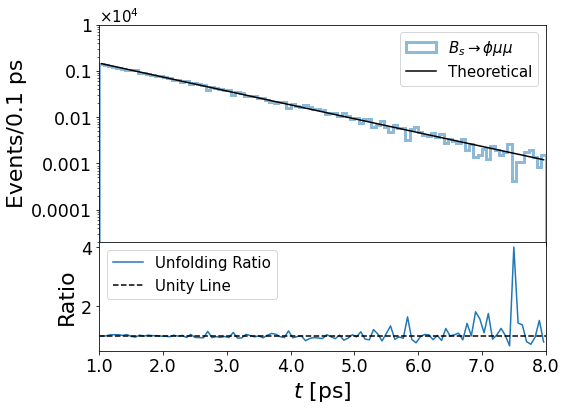

In [54]:
# Create the figure and GridSpec layout
f = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1]) 

# The first subplot (Histogram and theoretical model)
ax0 = plt.subplot(gs[0])
ax0.set_yscale("log")  # Set logarithmic scale for y-axis

# Plot the histogram for B_s/Bar{B}_s -> phi mu mu
ns, edges, _ = ax0.hist(
    df_s_train['Delta_t'],
    weights=df_s_train['preweight'] / train_test_split,
    histtype='step',
    lw=3,
    alpha=0.5,
    range=range_,
    bins=bins_,
    label=r'$B_s\to\phi\mu\mu$'
)

# Overlay the theoretical model
ax0.plot((edges[1:] + edges[:-1]) / 2, heights_ut, label='Theoretical', color='black')

# Calculate the unfolding ratio and handle potential division by zero
unfold = np.divide(heights_ut, ns, where=(ns != 0))  # Avoid division by zero

# Format the y-ticks for better readability
locs = ax0.get_yticks()
ax0.set_yticks(locs, map(lambda x: "%.2g" % x, locs * 1e-4))
ax0.text(0, 1.01, r'$\times 10^4$', fontsize=15, transform=ax0.transAxes)

# Set limits for the axes
ax0.set_xlim(*range_)
ax0.set_ylim(2e-1, 1e4)
ax0.legend(fontsize=15)

# The second subplot (Unfolding Ratio)
ax1 = plt.subplot(gs[1], sharex=ax0)  # Shared x-axis with ax0
ax1.plot((edges[1:] + edges[:-1]) / 2, unfold, color='C0', label='Unfolding Ratio')
ax1.axhline(1, color='k', linestyle='--', label='Unity Line')  # Add a unity line

# Format the x-ticks
plt.setp(ax0.get_xticklabels(), visible=False)  # Hide x-tick labels for the first subplot
yticks = ax1.yaxis.get_major_ticks()
yticks[-1].label1.set_visible(False)  # Remove the last y-tick label for ax1

# Adjust layout to remove gaps between subplots
plt.subplots_adjust(hspace=0.0)

# Format x-ticks for the second subplot
locs = ax1.get_xticks()
ax1.set_xticks(locs, map(lambda x: "%.1f" % x, locs * 1e12))

# Set axis labels
ax1.set_xlabel(r"$t$ [ps]", fontsize=22)
ax0.set_ylabel(f"Events/{(range_[1] - range_[0]) / bins_ * 1e12:.1f} ps", fontsize=22)
ax1.set_ylabel("Ratio", fontsize=22)

# Adjust tick parameters for better readability
ax0.tick_params(axis='both', which='major', labelsize=17.5)
ax1.tick_params(axis='both', which='major', labelsize=17.5)

# Show legend for the second subplot
ax1.legend(fontsize=15)

# Show the plot
plt.show()


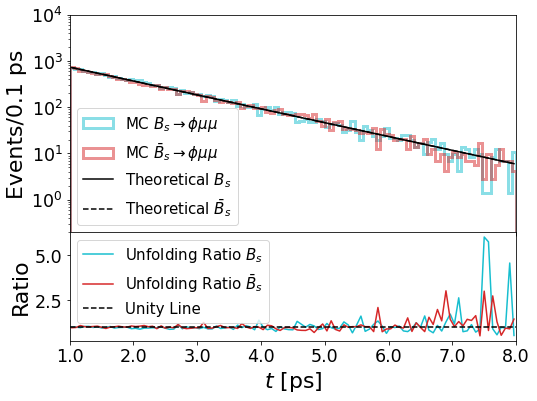

In [55]:
# Create the figure and GridSpec layout
f = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1]) 

# The first subplot (Histograms for B_s and B_bar)
ax0 = plt.subplot(gs[0])
ax0.set_yscale("log")  # Set logarithmic scale for y-axis

# Plot the histogram for B_s decay events
ns1, edges, _ = ax0.hist(
    df_s_B_train['Delta_t'],
    weights=df_s_B_train['preweight'] / train_test_split,
    histtype='step',
    lw=3,
    alpha=0.5,
    range=range_,
    bins=bins_,
    label=r'MC $B_s\to\phi\mu\mu$',
    color='C9'
)

# Plot the histogram for B_bar decay events
ns2, edges, _ = ax0.hist(
    df_s_Bb_train['Delta_t'],
    weights=df_s_Bb_train['preweight'] / train_test_split,
    histtype='step',
    lw=3,
    alpha=0.5,
    range=range_,
    bins=bins_,
    label=r'MC $\bar{B}_s\to\phi\mu\mu$',
    color='C3'
)

# Overlay the theoretical heights
ax0.plot((edges[1:] + edges[:-1]) / 2, heights1, label='Theoretical $B_s$', color='black')
ax0.plot((edges[1:] + edges[:-1]) / 2, heights2, color='black', linestyle='--', label=r'Theoretical $\bar{B}_s$')

# Calculate the unfolding ratios and handle potential division by zero
unfold1 = np.divide(heights1, ns1, where=(ns1 != 0))  # Avoid division by zero
unfold2 = np.divide(heights2, ns2, where=(ns2 != 0))  # Avoid division by zero

# Set limits and labels for the first subplot
ax0.set_xlim(*range_)
ax0.set_ylim(2e-1, 1e4)
ax0.legend(fontsize=15)

# The second subplot (Unfolding Ratios)
ax1 = plt.subplot(gs[1], sharex=ax0)  # Share x-axis with ax0
ax1.plot((edges[1:] + edges[:-1]) / 2, unfold1, color='C9', label=r'Unfolding Ratio $B_s$')
ax1.plot((edges[1:] + edges[:-1]) / 2, unfold2, color='C3', label=r'Unfolding Ratio $\bar{B}_s$')
ax1.axhline(1, color='k', linestyle='--', label='Unity Line')  # Add a unity line for reference

# Format the x-ticks for better readability
plt.setp(ax0.get_xticklabels(), visible=False)  # Hide x-tick labels for the first subplot
yticks = ax1.yaxis.get_major_ticks()
yticks[-1].label1.set_visible(False)  # Remove the last y-tick label for ax1

# Adjust layout to remove gaps between subplots
plt.subplots_adjust(hspace=0.0)

# Format x-ticks for the second subplot
locs = ax1.get_xticks()
ax1.set_xticks(locs, map(lambda x: "%.1f" % x, locs * 1e12))

# Set axis labels
ax1.set_xlabel(r"$t$ [ps]", fontsize=22)
ax0.set_ylabel(f"Events/{(range_[1] - range_[0]) / bins_ * 1e12:.1f} ps", fontsize=22)
ax1.set_ylabel("Ratio", fontsize=22)

# Adjust tick parameters for better readability
ax0.tick_params(axis='both', which='major', labelsize=17.5)
ax1.tick_params(axis='both', which='major', labelsize=17.5)

# Show legends for both subplots
ax0.legend(fontsize=15)
ax1.legend(fontsize=15)

# Show the plot
plt.show()


### rescale the fit

In [56]:
# given a value in time, find which time bin it is in
# if it is beyond the range, just gives idx=-1
def find_bins(edges, value):
    bins = []
    # Initialize bin index to -1 if the value does not fall in any bin
    bin_index = -1
    # Loop through the edges to find the bin
    for i in range(len(edges) - 1):
        if edges[i] <= value < edges[i + 1]:
            bin_index = i
            break
    # If the value is exactly the last edge value, put it in the last bin
    if value == edges[-1]:
        bin_index = len(edges) - 2
    return bin_index

In [57]:
# multiply the unfolding ratio into the dataframe
def add_uf(df, unfold):
    df_ = df.copy()
    ws = []    # the weight
    b_lt = []    # the index of the bin
    count_out = 0
    # loop every data sample, and fine the bin it is in
    # multiply the preweight (the one rescaled to match FCC yield) and the folding ratio
    for i, r in df_.iterrows():
        b_idx = find_bins(edges, r['Delta_t'])
        b_lt.append(b_idx)
        if b_idx == -1:
            count_out += 1
            w = 0
        else:
            w = unfold[b_idx] * r['preweight']/train_test_split
        ws.append(w)
    
    # add the new weight into the dataframe
    df_.loc[df_.index, 'unfold'] = ws
    
#     print(f"{count_out} out of range")
    return df_

In [58]:
# for untagged 
df_s_test = add_uf(df_s_test, unfold)
df_s_test['unfold'] = df_s_test['unfold'] * D_time

# for tagged
df_s_B_test = add_uf(df_s_B_test, unfold1)
df_s_B_test['unfold'] = df_s_B_test['unfold'] * D_time * P_bm**0.5
df_s_Bb_test = add_uf(df_s_Bb_test, unfold2)
df_s_Bb_test['unfold'] = df_s_Bb_test['unfold'] * D_time * P_bm**0.5

### Fit $D_f$

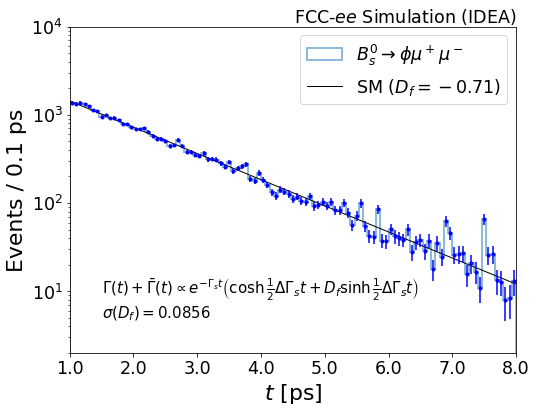

In [59]:
"""
Plots the histogram of Delta_t with an unfolding fit.

Parameters:
- df_s_test: DataFrame containing the data to be plotted
- range_: Range of the histogram
- bins_: Number of bins for the histogram
- df_s_test_SM: Value of D_f for the Standard Model
- ns_discount, nb, nc: Discounts for normalization
- unfold: Unfolding ratios
"""
f, ax = plt.subplots(1, figsize=(8, 6))

# Plot histogram
h_w, edges, _ = ax.hist(df_s_test['Delta_t'], histtype='step', lw=2, alpha=0.5,
                         weights=df_s_test['unfold'], range=range_, bins=bins_,
                         label=r'$B^0_s\to\phi\mu^+\mu^-$')

plt.plot(t, untag * fac, lw=1, color='k', label=rf'SM ($D_f={Df_SM}$)')

# Calculate errors
ns_conserv = h_w * ns_discount
nb_conserv = nb * nb_discount * unfold
nc_conserv = nc * nc_discount * unfold
er = (ns_conserv + nb_conserv + nc_conserv)**0.5 / ns_conserv
er_abs = er * h_w

# Add error bars
plt.errorbar((edges[1:] + edges[:-1]) / 2, h_w, yerr=er_abs, fmt='b.')

# Curve fitting
popt, pcov = curve_fit(pdf_untagged, (edges[1:] + edges[:-1]) / 2, h_w,
                       sigma=er_abs, absolute_sigma=True,
                       bounds=((-1.0001, 0), (1.0001, np.inf)))

# Get sigma of the fit result
sd_Df = pcov[0][0]**0.5
ax.text(1.5e-12, 0.5e1, r'$\Gamma (t)+\bar{\Gamma} (t) \propto e^{-\Gamma_s t}\left(\cosh{\frac{1}{2}\Delta\Gamma_s t}+D_f\sinh{\frac{1}{2}\Delta\Gamma_s t}\right)$' + 
        '\n' + rf'$\sigma(D_f)={sd_Df:.4f}$', fontsize=15)

# Plotting adjustments
plt.yscale('log')
locs = ax.get_xticks()
ax.set_xticks(locs, map(lambda x: "%.1f" % x, locs * 1e12))

ax.set_xlabel(r"$t$ [ps]", fontsize=22)
ax.set_ylabel(f"Events / {(range_[1] - range_[0]) / bins_ * 1e12:.1f} ps", fontsize=22)
ax.tick_params(axis='both', which='major', labelsize=17.5)

ax.text(1, 1.03, r'FCC-$ee$ Simulation (IDEA)', horizontalalignment='right',
        verticalalignment='center', transform=ax.transAxes, fontsize=17.5)
ax.legend(fontsize=17.5)

ax.set_xlim(*range_)
ax.margins(x=0.)
ax.set_ylim(2e0, 1e4)

f.savefig("Df.pdf")
plt.show()

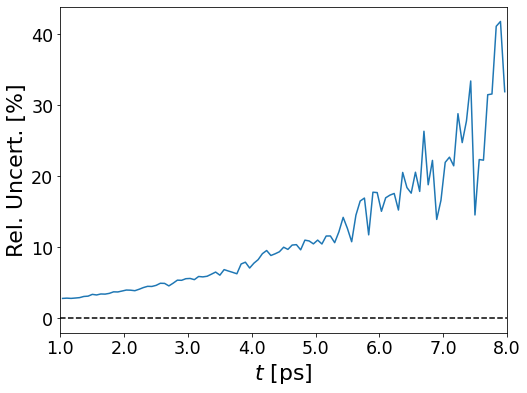

In [60]:
# Assuming `edges` and `er` are already defined
f, ax = plt.subplots(1, figsize=(8, 6))

# Convert relative uncertainty to percentage and plot
plt.errorbar((edges[1:] + edges[:-1]) / 2, er * 100, color='C0', 
             label='Relative Uncertainty', markersize=5, capsize=4)

# Horizontal line at y=0 for reference
plt.axhline(0, linestyle='--', color='k')

# Adjust ticks and labels
locs = ax.get_xticks()
ax.set_xticks(locs, map(lambda x: "%.1f" % x, locs * 1e12))

ax.set_xlabel(r"$t$ [ps]", fontsize=22)
ax.set_ylabel(f"Rel. Uncert. [%]", fontsize=22)
ax.tick_params(axis='both', which='major', labelsize=17.5)

# Setting limits and adding margins
ax.set_xlim(*range_)
ax.margins(x=0.)

# Show the plot
plt.show()


### Cf and Sf

In [61]:
# the % precision need to *2^0.5, because we have half of the samples only
# which means sqrt(n/2)/(n/2), so the % presicion goes *2^0.5 larger
# then change it back to the discount (1-%)
ns1_discount = ns2_discount = 1 - (1 - ns_discount) * 2**0.5


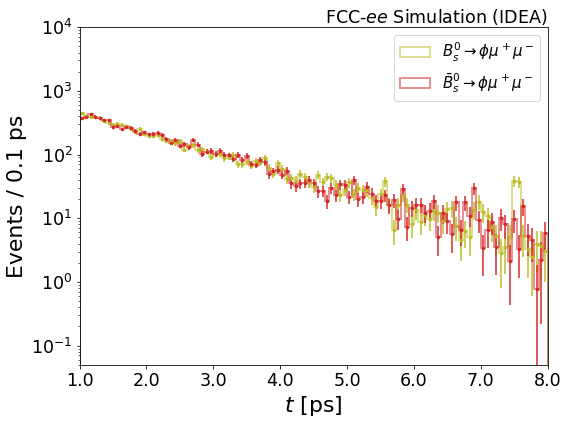

In [62]:
f, ax = plt.subplots(1, figsize=(8, 6))

# Plot histograms with weights for the two processes
h_w1, edges, _ = plt.hist(df_s_B_test['Delta_t'], histtype='step', lw=2, alpha=0.5, 
                          weights=df_s_B_test['unfold'], range=range_, bins=bins_, 
                          label=r'$B_s^0\to\phi\mu^+\mu^-$', color='C8')

h_w2, edges, _ = plt.hist(df_s_Bb_test['Delta_t'], histtype='step', lw=2, alpha=0.5, 
                          weights=df_s_Bb_test['unfold'], range=range_, bins=bins_, 
                          label=r'$\bar{B}^0_s\to\phi\mu^+\mu^-$', color='C3')

# ============================================
#     Get Error
# ============================================
ns1_conserv = h_w1 * ns1_discount
ns2_conserv = h_w2 * ns2_discount

# Calculate the relative uncertainty
er1 = np.where(ns1_conserv > 0, 1 / np.sqrt(ns1_conserv), 0)  # Avoid division by zero
er2 = np.where(ns2_conserv > 0, 1 / np.sqrt(ns2_conserv), 0)  # Avoid division by zero

# Absolute errors
er_abs1 = er1 * h_w1
er_abs2 = er2 * h_w2

# Plotting error bars
plt.errorbar((edges[1:] + edges[:-1]) / 2, h_w1, yerr=er_abs1, color='C8', fmt='.', markersize=5)
plt.errorbar((edges[1:] + edges[:-1]) / 2, h_w2, yerr=er_abs2, color='C3', fmt='.', markersize=5)

plt.yscale('log')

# Configure ticks and labels
locs = ax.get_xticks()
ax.set_xticks(locs, map(lambda x: "%.1f" % x, locs * 1e12))
ax.set_xlabel(r"$t$ [ps]", fontsize=22)
ax.set_ylabel(f"Events / {(range_[1] - range_[0]) / bins_ * 1e12:.1f} ps", fontsize=22)

# Adding annotation text
ax.text(1, 1.03, r'FCC-$ee$ Simulation (IDEA)', horizontalalignment='right',
        verticalalignment='center', transform=ax.transAxes, fontsize=17.5)

ax.tick_params(axis='both', which='major', labelsize=17.5)
ax.legend(fontsize=15)

# Set axis limits and margins
ax.set_xlim(*range_)
ax.margins(x=0.)
ax.set_ylim(0.5e-1, 10e3)  # Adjust y-limits as necessary

plt.tight_layout()
f.savefig(f"CfSf_osc.pdf")

plt.show()

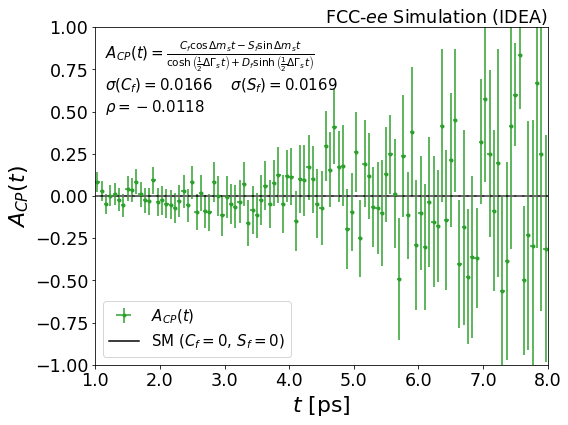

In [63]:
# Calculate absolute uncertainty for a_AP
er_acp = (ns1_conserv + ns2_conserv)**-0.5 * P_bm**-0.5
er_acp_abs = er_acp   # This already gives the absolute uncertainty of the a_AP

f, ax = plt.subplots(1, figsize=(8, 6))

# Error bar for A_CP with absolute uncertainty
ax.errorbar((edges[1:] + edges[:-1]) / 2, (h_w1 - h_w2) / (h_w1 + h_w2), 
            yerr=er_acp_abs, xerr=(edges[2] - edges[1]) / 2, color='C2', 
            fmt='.', label=r'$A_{CP}(t)$')

# ============================================
#     Fit the data
# ============================================
poptap, pcovap = curve_fit(pdf_acp_SM, 
                           (edges[1:] + edges[:-1]) / 2, 
                           (h_w1 - h_w2) / (h_w1 + h_w2), 
                           sigma=er_acp_abs, absolute_sigma=True, 
                           bounds=((-1, -1), (1, 1)))

Cf, Sf = poptap
var_C, var_S = pcovap[0, 0], pcovap[1, 1]
cov_CS = pcovap[1, 0]

# Plot the Standard Model prediction
plt.plot(t, pdf_acp_SM(t, Cf_SM, Sf_SM), color='k', 
         label=rf'SM ($C_f= {Cf_SM},\, S_f= {Sf_SM}$)')

# Configure ticks and labels
locs = ax.get_xticks()
ax.set_xticks(locs, map(lambda x: "%.1f" % x, locs * 1e12))
ax.set_xlabel(r"$t$ [ps]", fontsize=22)
ax.set_ylabel(r"$A_{CP}(t)$", fontsize=22)
ax.tick_params(axis='both', which='major', labelsize=17.5)

# Adding annotation text
ax.text(1, 1.03, r'FCC-$ee$ Simulation (IDEA)', 
        horizontalalignment='right', verticalalignment='center', 
        transform=ax.transAxes, fontsize=17.5)

ax.axhline(0, linestyle='--', color='grey')

# Set axis limits
lim = 1
ax.set_xlim(*range_)
ax.set_ylim(-lim, lim)

# Fill areas for clarity
ax.fill_between(np.linspace(*range_, 2), 1, lim, color='grey', alpha=0.1)
ax.fill_between(np.linspace(*range_, 2), -lim, -1, color='grey', alpha=0.1)
ax.axhline(0, linestyle='--', color='grey', zorder=-1)

# Uncertainty text
sd_Cf = var_C**0.5
sd_Sf = var_S**0.5
rho = cov_CS / (sd_Cf * sd_Sf)

text_pos = (1.15e-12, 0.5)
ax.text(*text_pos, 
        r'$A_{CP}(t)= \frac{C_f\cos{\Delta m_s t} - S_f\sin{\Delta m_s t}}{\cosh{\left(\frac{1}{2}\Delta\Gamma_s t\right)} + D_f\sinh{\left(\frac{1}{2}\Delta\Gamma_s t\right)}}$' + 
        '\n' + rf'$\sigma(C_f)={sd_Cf:.4f}$' + 
        '\t' + rf'$\sigma(S_f)={sd_Sf:.4f}$' + 
        '\n' + rf'$\rho={rho:.4f}$', fontsize=15)

ax.legend(fontsize=15, loc=3, reverse=1)

plt.tight_layout()
f.savefig(f"CfSf_acp.pdf")

plt.show()

### modulo time

In [64]:
# Generate modulo time values
t_mod = np.linspace(*range_, bins_*fac*100)
t_mod = t_mod % (2*np.pi / Deltam)
t_mod_plot = np.linspace(0, 2*np.pi / Deltam, bins_*fac*100)


In [65]:
t_acp = pdf_acp_SM(t, Cf_SM, Sf_SM)

t_acp = t_acp * (np.cosh(0.5*DeltaGamma*t) + Df_SM * np.sinh(0.5*DeltaGamma*t))

In [66]:
df_s_B_test['Delta_t_Mod'] = df_s_B_test['Delta_t'] % (2*np.pi / Deltam)
df_s_Bb_test['Delta_t_Mod'] = df_s_Bb_test['Delta_t'] % (2*np.pi / Deltam)

df_s_B_test['Delta_t_Mod'] = df_s_B_test['Delta_t_Mod']  * (np.cosh(0.5*DeltaGamma*1e-12*df_s_B_test['Delta_t']) + Df_SM * np.sinh(0.5*DeltaGamma*1e-12*df_s_B_test['Delta_t']))
df_s_Bb_test['Delta_t_Mod'] = df_s_Bb_test['Delta_t_Mod']  * (np.cosh(0.5*DeltaGamma*1e-12*df_s_Bb_test['Delta_t']) + Df_SM * np.sinh(0.5*DeltaGamma*1e-12*df_s_Bb_test['Delta_t']))

9434.598529773113 9396.70014366481


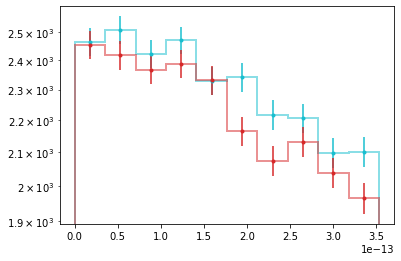

In [67]:
bins_mod = 10

ns1_mod_raw, edges_mod, _ = plt.hist(df_s_B_test['Delta_t_Mod'], histtype='step', lw=2, alpha=0.5, 
                         range=[0, (2*np.pi / Deltam)], bins=bins_mod, 
                         label=r'MC $B_s\to\phi\mu\mu$', color='C9');

ns2_mod_raw, edges_mod, _ = plt.hist(df_s_Bb_test['Delta_t_Mod'], histtype='step', lw=2, alpha=0.5, 
                         range=[0, (2*np.pi / Deltam)], bins=bins_mod, 
                         label=r'MC $\bar{B}_s\to\phi\mu\mu$', color='C3');

plt.errorbar((edges_mod[1:] + edges_mod[:-1])/2, ns1_mod_raw, yerr=ns1_mod_raw**0.5, fmt='C9.')
plt.errorbar((edges_mod[1:] + edges_mod[:-1])/2, ns2_mod_raw, yerr=ns2_mod_raw**0.5, fmt='C3.')
plt.yscale('log')



ns1_mod_rel_uncert = ns1_mod_raw**-0.5
ns1_mod_rel_uncert[ns1_mod_rel_uncert == np.inf] = 1
ns2_mod_rel_uncert = ns2_mod_raw**-0.5
ns2_mod_rel_uncert[ns2_mod_rel_uncert == np.inf] = 1

# if underestimate siganl
ns1_mod_discount = 1 - ns1_mod_rel_uncert
ns2_mod_discount = 1 - ns2_mod_rel_uncert

plt.yscale('log')

print(sum(h_w1), sum(h_w2))

9434.598529773113 9396.70014366481


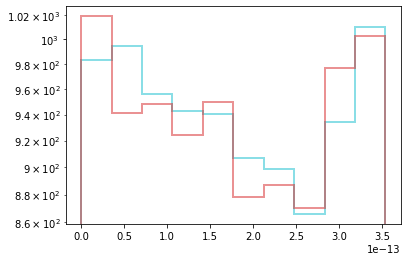

In [68]:
h_w1_mod, edges_mod, _ = plt.hist(df_s_B_test['Delta_t_Mod'], histtype='step', lw=2, alpha=0.5, weights=df_s_B_test['unfold'], 
                         range=[0, (2*np.pi / Deltam)], bins=bins_mod, 
                         label=r'MC $B_s\to\phi\mu\mu$', color='C9');

h_w2_mod, edges_mod, _ = plt.hist(df_s_Bb_test['Delta_t_Mod'], histtype='step', lw=2, alpha=0.5, weights=df_s_Bb_test['unfold'], 
                         range=[0, (2*np.pi / Deltam)], bins=bins_mod, 
                         label=r'MC $\bar{B}_s\to\phi\mu\mu$', color='C3');



plt.yscale('log')

print(sum(h_w1), sum(h_w2))

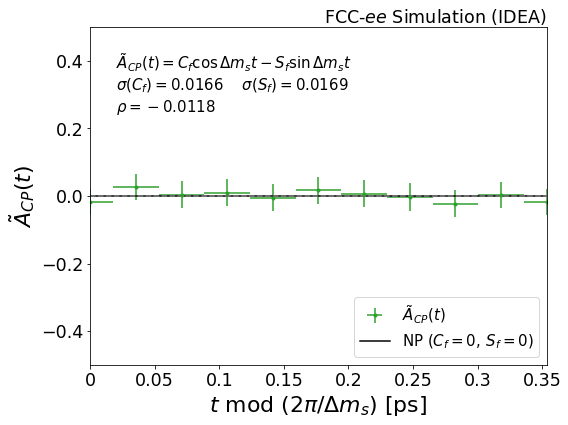

In [69]:
# Calculate conserved values and uncertainties
ns1_mod_conserv = h_w1_mod * ns1_mod_discount
ns2_mod_conserv = h_w2_mod * ns2_mod_discount
er_acp_mod = (ns1_mod_conserv + ns2_mod_conserv) ** -0.5 * P_bm ** -0.5
er_acp_mod_abs = er_acp_mod  # Absolute uncertainty for a_AP

# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))

# Calculate x and y positions for error bars
x_pos = edges_mod[:-1]
x_pos = np.append(x_pos, x_pos[-1] + (x_pos[1] - x_pos[0]))  # Extend x_pos for smooth transition
y_pos = (h_w1_mod - h_w2_mod) / (h_w1_mod + h_w2_mod)
y_pos = np.append(y_pos, y_pos[0])  # Close the loop for smooth plotting
y_err = er_acp_mod_abs
y_err = np.append(y_err, y_err[0])  # Close the error array for smooth plotting

# Plot the CP asymmetry with error bars
ax.errorbar(x_pos, y_pos, yerr=y_err, xerr=(edges_mod[1] - edges_mod[0]) / 2, 
            color='C2', fmt='.', label=r'$\tilde{A}_{CP}(t)$')

# Fit and plot the model
ax.plot(t_mod_plot, pdf_acp_mod(t_mod_plot, Cf_SM, Sf_SM), 
        color='k', label=rf'NP ($C_f= {Cf_SM},\, S_f= {Sf_SM}$)')

# Set x-axis formatting
locs = ax.get_xticks()
ax.set_xticks(locs, map(lambda x: "%.2g" % x, locs * 1e12))  # Scale x-axis to ps

# Set labels and title
ax.set_xlabel(r"$t$ mod $(2\pi/\Delta m_s)$ [ps]", fontsize=22)
ax.set_ylabel(r"$\tilde{A}_{CP}(t)$", fontsize=22)
ax.tick_params(axis='both', which='major', labelsize=17.5)

# Add simulation information
ax.text(1, 1.03, r'FCC-$ee$ Simulation (IDEA)', 
        horizontalalignment='right', verticalalignment='center', 
        transform=ax.transAxes, fontsize=17.5)

# Set limits for x and y axes
ax.set_xlim(0, t_mod.max())
lim = 0.5
ax.set_ylim(-lim, lim)

# Add shaded areas to indicate limits
ax.fill_between(np.linspace(0, 1e-11, 2), 1, lim, color='grey', alpha=0.1)
ax.fill_between(np.linspace(0, 1e-11, 2), -lim, -1, color='grey', alpha=0.1)

# Add a horizontal line at y=0
ax.axhline(0, linestyle='--', color='grey')

# Calculate uncertainties
sd_Cf = var_C ** 0.5
sd_Sf = var_S ** 0.5
rho = cov_CS / (sd_Cf * sd_Sf)

# Add parameter information to the plot
text_pos = (0.2e-13, 0.25)
ax.text(*text_pos, r'$\tilde{A}_{CP}(t) = C_f\cos{\Delta m_s t} - S_f\sin{\Delta m_s t}$' + '\n' + 
        rf'$\sigma(C_f)={sd_Cf:.4f}$' + '\t' + rf'$\sigma(S_f)={sd_Sf:.4f}$' + '\n' + 
        rf'$\rho={rho:.4f}$', fontsize=15)

# Add legend and display the plot
ax.legend(fontsize=15, loc=4, reverse=True)

plt.tight_layout()
fig.savefig(f"CfSf_acp_mod_{Cf_SM}_{Sf_SM}.pdf")

plt.show()

### Constraining $C_f$, $S_f$ from other measurements

In [70]:
# Create an array of angles from 0 to 2*pi for plotting
theta = np.linspace(0, 2 * np.pi, 1000)

# Define constants related to decay rates
Gamma = 1 / 1.520 * 1e12  # Decay rate (s^-1)
DeltaGamma = 0.084 * 1e12  # Difference in decay rates (s^-1)
Deltam = 17.765 * 1e12  # Mass difference (s^-1)

# Standard deviation of some factor (possibly related to CP violation)
sd_Df = 0.106

# Limit on the CP asymmetry
A_CP_lim = 9.6e-3


In [71]:
def find_counter_from_CfSf(pcovap, theta):
    eigenvalues, eigenvectors = np.linalg.eig(pcovap)
    ellipsis = (np.sqrt(eigenvalues[None,:]) * eigenvectors) @ [np.sin(theta), np.cos(theta)] 
    return ellipsis[0,:], ellipsis[1,:]


x_CfSf, y_CfSf = find_counter_from_CfSf(pcovap, theta)
x_CfSf2, y_CfSf2 = find_counter_from_CfSf(pcovap*4, theta)

In [72]:
def find_counter_from_ACP(A_CP_lim_up, A_CP_lim_lo, theta):
    Df = Df_SM
    fac = (4*Gamma**2 - DeltaGamma**2) / ((Gamma**2 + Deltam**2) * (4*Gamma + 2*Df*DeltaGamma))
    r = A_CP_lim_lo
    x, y = r*np.cos(theta), r*np.sin(theta)
    return x, y


theta_half = np.linspace(0, np.pi, 1000);
x_ACP, y_ACP = find_counter_from_ACP(A_CP_lim, -A_CP_lim, theta_half)
x_ACP2, y_ACP2 = find_counter_from_ACP(A_CP_lim*2, -A_CP_lim*2, theta_half)

In [73]:
Df = Df_SM
fac = (4*Gamma**2 - DeltaGamma**2) / ((Gamma**2 + Deltam**2) * (4*Gamma + 2*Df*DeltaGamma))

x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)

xx, yy = np.meshgrid(x, y)
acp = fac * (Gamma * xx - Deltam * yy)

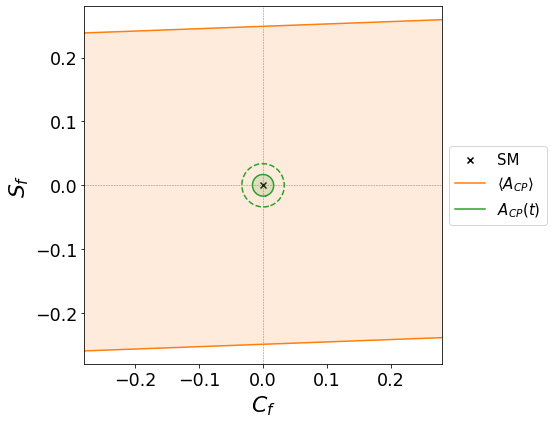

In [74]:
f, ax = plt.subplots(1, figsize=(8,6))

theta = np.linspace(0, 2*np.pi, 1000);


plt.scatter(0, 0, marker='x', color='k', label="SM")


ax.contour(xx, yy, acp, levels=[A_CP_lim], colors=['C1'], linestyles=['solid'])
ax.contour(xx, yy, acp, levels=[-A_CP_lim], colors=['C1'], linestyles=['solid'])
ax.contourf(xx, yy, acp, levels=[-A_CP_lim, A_CP_lim], colors='C1', alpha=0.15)


ax.plot(99, 99, color='C1', label=r'$\langle A_{CP}\rangle$')

ax.plot(x_CfSf, y_CfSf, color='C2', label=r'$A_{CP}(t)$')
ax.fill(x_CfSf, y_CfSf, color='C2', alpha=0.15)
ax.plot(x_CfSf2, y_CfSf2, color='C2', linestyle='--')

# lim = 0.025
lim = 0.28
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
# ax.locator_params(nbins=7, axis='x')

# locs = ax.get_yticks()
# ax.set_yticks(locs[::2])
# ax.set_xticks(np.arange(-lim, lim+0.01, 0.01))
# ax.set_yticks(np.arange(-lim, lim+0.01, 0.01))
ax.set_aspect('equal', adjustable='box')

ax.set_xlabel(r"$C_f$", fontsize=22);
ax.set_ylabel(r"$S_f$", fontsize=22);
ax.tick_params(axis='both', which='major', labelsize=17.5)

ax.axvline(0, color='grey', zorder=-1, lw=0.5, linestyle='--')
ax.axhline(0, color='grey', zorder=-1, lw=0.5, linestyle='--')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=15)
# ax.legend(fontsize=15)
# ax.text(-0.017, 0.011, rf'$\sigma(C_f)={sd_Cf:.2g}$'+'\n'+rf'$\sigma(S_f)={sd_Sf:.2g}$'+'\n'+rf'$\rho={rhoCS:.2g}$', fontsize=15)
plt.tight_layout()
f.savefig('summary.pdf')